Archtop Guitar Builder v5


---



**What is this?**

It creates smooth curved guitar 'archtops' using curtate cycloid curves. It's for those building their own archtop guitars.

You input your guitar outline, some parameters and then it will generate a contour map for carving the upper surface of the guitar arched top plate (and arched back plates).

It does thin a cloud-based Google Colab Python Notebook (https://colab.research.google.com/#create=true) so you don't need any installed stuff.


**Preword**

Before starting it's worth understanding that the final measurements are based on heights from a plate base.

"Engineering Curve" is the centre of a thickness curve where the thickness is zero. If a curve has any thickness it's added 1/2 above and 1/2 below this line to create the "upper surface" and "lower surface" curves.

The general structure is as follows, given a 5 mm thickness:

---- Upper Surface line ---- the outside surface of the plate
+ 2.5 mm 1/2 thickness
+ engineering curve line
+ 2.5 mm 1/2 thickness
+ 1.0 mm recurve depth

---- Lower Surface line ---- the inside surface of the plate
+ 1.0 mm base padding (sanded away at the end for levelling)

---- PLATE Base (0mm height) ----

This means that contour maps  at the end will be generated in accordance to this structure for the upper surface line.

Important - READ the note about mirroring the rear plate contour map further down.

Notes:
1. This is a guide - constant thickness is assumed, it's up to the luthier to thickness for purpose and tone.
2. Edge recurve is left to the luthier to shape as desired.
3. Functions typically work on the engineering curve




---


OUTLINE FILE Information
The outline file is a CSV file with three columns:
* "Point" - this is the increasing order of points in an anti-clockwise order. This is important as it's used to interpolate for resampling.
* "X" - this is the X position along the Y=0 centre line from the front of the guitar.
* "Y" - this the distance above or below the centreline (positive above, negative below).

Hints and tips:
* The code expects this outline to be the inside edge of the linings (where the curtate cyloid arch recurve lowest point will sit).
* It's assumed millimeters, same as the parameters in the cells below.
* You will need to upload the outline csv file into the colab filesystem root directory for the code to find.
* If in doubt have a look at 'GOR.csv' which is my real life guitar outline file I've used.



---



INSTRUCTIONS:

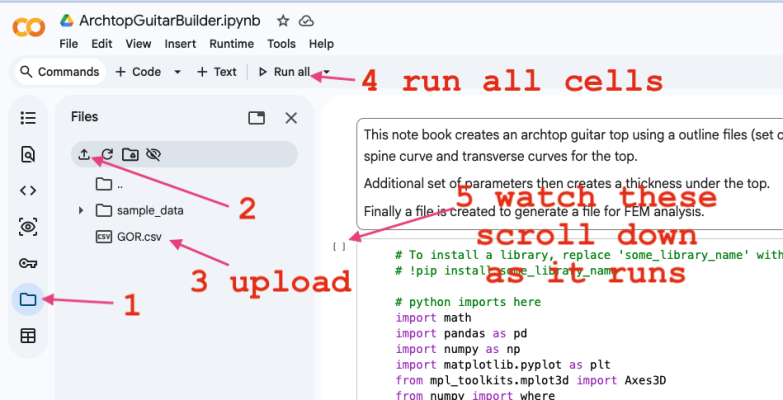

1. Click here to show the file system
2. Click here to upload either the GOR.csv or your own outline .csv (don't forget to change the filename in the parameters)
3. Your file will now appear here, note it will be deleted if the runtime is shutdown, so you will need to re-upload. Don't keep your gold copy of your outline file in a colab filing system.
4. Then simply "Run All" and the python code should then run and through each cell automatically.
5. It will then create any graphs or contour maps after each cell, so scroll down (the contour maps are generated as the last cells).


---



In [ ]:
# @title
# To install a library, replace 'some_library_name' with the actual library you want to install
# !pip install some_library_name

# python imports here
import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import where
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.collections # Import explicitly for type checking
from scipy.interpolate import griddata
from matplotlib.lines import lineStyles

In [ ]:
Parameter_OutlineFilename = "GOR.csv" # filename of the outline file (inside edge of linings)

# parameters, in mm
Parameter_GuitarOutlineMinX = 0     # centre line minimum point - this is the reference point for all measurements
Parameter_GuitarOutlineMaxX = 475   # centre line maximum point for Y=0, tail forks can continue past this.

Parameter_BridgeXPoint  = 312       # this is used for the spine to create the highest point on the guitar front for the bridge
Parameter_BridgeWidth   = 72        # not currently used, may use to create a rectangle on the plot
Parameter_BridgeLength  = 10        # not currently used, may use to create a rectangle on the plot
Parameter_BridgeLoad    = 24        # not currently used

Parameter_MeasuredFrontDomeHeight = 12      # bridge height above the engineering zero line
Parameter_MeasuredRearDomeHeight = 15       # rear dome height above the engineering zero line
Parameter_EngRecurveDepth = 1               # engineering curve recurve depth below engineering zero line
Parameter_Thickness = 5                     # constant top thicknesss, 1/2 above the engineering curve, 1/2 below the engineering curve
Parameter_OutlineRibLiningThickness = 10    # this is the width of the lining between inside and outside of the guitar
Parameter_OutlineRibLiningRecuveOffset = 0  # this is the low point recurve offset from the inside edge (start of the engineering curve)

# these are the 'low resolution' contours for the contour maps - note this is height above the plate base.
Parameter_ArchContoursList = [  2,3,4, 5, 5.5, 6.0, 6.5, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13, 14, 15, 16, 17, 18, 19, 19.5 ]
Parameter_ArchRearContoursList = [ 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16, 17, 18, 19, 20, 21, 22, 23 ]

Parameter_BasePadding = 1   # this paramter provides a distance between the plate base and the lower surface of the recurve

# Calculate a few points
# On the Engineering curves heights above the base
# Note the upper surface will be +thickness/2 and the lower surface -thickness/2 from the engineering curve/dome
RecurveEngineeringHeight       = Parameter_Thickness/2.0 + Parameter_BasePadding
RimEngineeringHeight           = RecurveEngineeringHeight + Parameter_EngRecurveDepth
FrontDomeEngineeringHeight     = RimEngineeringHeight + Parameter_MeasuredFrontDomeHeight
RearDomeEngineeringHeight      = RimEngineeringHeight + Parameter_MeasuredRearDomeHeight


In [ ]:
# @title
def resample_outline_at_x_intervals(df_outline, x_interval=5.0):
  """
  Resamples a 2D outline DataFrame by inserting new points at specified x_intervals
  to ensure uniform distribution of points. If the original x_interval is very small,
  this function ensures a minimum density. It then re-sorts all points in anti-clockwise order.
  For vertical segments, it resamples along the Y-axis using the same interval.

  Args:
    df_outline (pd.DataFrame): DataFrame with 'X' and 'Y' columns representing
                                 the outline points, assumed to be in anti-clockwise order.
    x_interval (float): The interval at which to resample new X (or Y for vertical) coordinates.

  Returns:
    pd.DataFrame: A new DataFrame with resampled and sorted outline points.
  """
  if df_outline.empty:
    return pd.DataFrame(columns=['X', 'Y'])

  # Initialize a DataFrame to store all original and new points
  all_points = df_outline.copy()

  # Iterate through each segment of the outline
  num_points = len(df_outline)
  for i in range(num_points):
    p1 = df_outline.iloc[i]
    p2 = df_outline.iloc[(i + 1) % num_points] # Connect last point to first

    x1, y1 = p1['X'], p1['Y']
    x2, y2 = p2['X'], p2['Y']

    # Handle vertical segments (resample normal to the segment - along X-axis)
    if abs(y2 - y1) < 1e-6: # Check for nearly horizontal line, so normal is vertical (along Y)
        segment_min_x = min(x1, x2)
        segment_max_x = max(x1, x2)

        start_multiple_x = (np.floor(segment_min_x / x_interval) + 1) * x_interval
        end_multiple_x = np.floor(segment_max_x / x_interval) * x_interval

        potential_x_coords = np.array([])
        if start_multiple_x <= end_multiple_x + 1e-9:
            potential_x_coords = np.arange(start_multiple_x, end_multiple_x + 1e-9, x_interval)

        new_x_coords = [x for x in potential_x_coords if x > min(x1, x2) and x < max(x1, x2)]

        if new_x_coords:
            new_y_coords = [y1] * len(new_x_coords)
            new_points_df = pd.DataFrame({'X': new_x_coords, 'Y': new_y_coords})
            all_points = pd.concat([all_points, new_points_df], ignore_index=True)
        continue # Move to the next segment after handling horizontal one

    # Handle non-horizontal segments (resample along Y-axis for better coverage for X-intervals)
    segment_min_y = min(y1, y2)
    segment_max_y = max(y1, y2)

    # Calculate the first multiple of x_interval that is strictly greater than segment_min_y
    start_multiple = (np.floor(segment_min_y / x_interval) + 1) * x_interval
    # Calculate the last multiple of x_interval that is less than or equal to segment_max_y
    end_multiple = np.floor(segment_max_y / x_interval) * x_interval

    potential_y_coords = np.array([])
    # Only create arange if the calculated range has potential points
    if start_multiple <= end_multiple + 1e-9: # Add epsilon to include end_multiple if it's exact
        potential_y_coords = np.arange(start_multiple, end_multiple + 1e-9, x_interval)

    # Filter potential_y_coords to include only points strictly between y1 and y2.
    new_y_coords = [y for y in potential_y_coords if y > min(y1, y2) and y < max(y1, y2)]

    # Interpolate X for each new Y
    if new_y_coords:
      # Linear interpolation formula: x = x1 + (x2 - x1) * (y - y1) / (y2 - y1)
      new_x_coords = x1 + (x2 - x1) * (np.array(new_y_coords) - y1) / (y2 - y1)
      new_points_df = pd.DataFrame({'X': new_x_coords, 'Y': new_y_coords})
      all_points = pd.concat([all_points, new_points_df], ignore_index=True)

  # Round coordinates for precision and remove duplicates
  all_points['X'] = all_points['X'].round(6)
  all_points['Y'] = all_points['Y'].round(6)
  resampled_df = all_points.drop_duplicates(subset=['X', 'Y']).reset_index(drop=True)

  # Sort by angle around the centroid to ensure anti-clockwise order
  centroid_x = resampled_df['X'].mean()
  centroid_y = resampled_df['Y'].mean()

  resampled_df['angle'] = np.arctan2(resampled_df['Y'] - centroid_y, resampled_df['X'] - centroid_x)
  resampled_df = resampled_df.sort_values(by='angle').reset_index(drop=True)
  resampled_df = resampled_df.drop(columns=['angle'])

  return resampled_df


In [ ]:
# @title
def create_enlarged_outline(df_outline, thickness):
  """
  Enlarges a 2D outline by offsetting each point along its outward-pointing normal vector.

  Args:
    df_outline (pd.DataFrame): DataFrame with 'X' and 'Y' columns representing the outline points.
                                 Assumes points are ordered (e.g., counter-clockwise).
    thickness (float): The distance by which to enlarge the outline. If 0, the original
                       DataFrame is returned.

  Returns:
    pd.DataFrame: A new DataFrame with the enlarged outline points, or the original
                  df_outline if thickness is 0.
  """
  if thickness == 0:
    return df_outline.copy()

  X = df_outline['X'].to_numpy()
  Y = df_outline['Y'].to_numpy()
  num_points = len(X)

  enlarged_X = []
  enlarged_Y = []

  for i in range(num_points):
    # Calculate tangent vector
    if i == 0:
      # For the first point, use vector from last to second point for smooth tangent
      p_prev = np.array([X[num_points - 1], Y[num_points - 1]])
      p_next = np.array([X[i + 1], Y[i + 1]])
    elif i == num_points - 1:
      # For the last point, use vector from second-to-last to first point
      p_prev = np.array([X[i - 1], Y[i - 1]])
      p_next = np.array([X[0], Y[0]])
    else:
      p_prev = np.array([X[i - 1], Y[i - 1]])
      p_next = np.array([X[i + 1], Y[i + 1]])

    tangent_vector = p_next - p_prev

    # Derive perpendicular normal vector (assuming counter-clockwise outline for outward normal)
    # If tangent is (tx, ty), normal is (-ty, tx)
    normal_vector = np.array([-tangent_vector[1], tangent_vector[0]])

    # Normalize the normal vector
    norm_magnitude = np.linalg.norm(normal_vector)
    if norm_magnitude > 0:
      unit_normal_vector = normal_vector / norm_magnitude
    else:
      # Handle case where tangent vector is (0,0), e.g., duplicate points
      unit_normal_vector = np.array([0.0, 0.0]) # Or raise an error/warning

    # Offset the original point
    current_point = np.array([X[i], Y[i]])
    offset_point = current_point + unit_normal_vector * thickness

    ox=0
    oy=0

    if offset_point[1]!=0 :

      if not pd.isna( offset_point[0] ):
        ox=math.floor(offset_point[0])
        enlarged_X.append(ox)
      if not pd.isna(offset_point[1]) :
        oy=math.floor(offset_point[1])
        enlarged_Y.append(oy)

    #enlarged_X.append(offset_point[0])
    #enlarged_Y.append(offset_point[1])

  return pd.DataFrame({'X': enlarged_X, 'Y': enlarged_Y})

In [ ]:
# @title
print(f"Loading outline from {Parameter_OutlineFilename}")
df_imported_inside = pd.read_csv(Parameter_OutlineFilename)

#if Parameter_OutlineRibLiningThickness > 0 :
#  df_imported = create_enlarged_outline(df_imported_inside, Parameter_OutlineRibLiningThickness)
#else:
df_imported = df_imported_inside
df_imported = resample_outline_at_x_intervals(df_imported, x_interval=10.0)

# Extract X, Y, Z coordinates
x_data = df_imported['X']
y_data = df_imported['Y']

# we have to adjust the values, note the MaxX is where Y=0
if Parameter_OutlineRibLiningThickness > 0 :
  Parameter_GuitarOutlineMinX = min(x_data)
  candidates = df_imported[df_imported['Y'] == 0]['X']
  Parameter_GuitarOutlineMaxX = max(candidates)
  print(f"Expanded outline: updating outline min and max x coordinates min = {Parameter_GuitarOutlineMinX} and max = {Parameter_GuitarOutlineMaxX}")

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Scatter plot the points
ax.scatter(x_data, y_data, s=10)

# Explicitly close the outline for plotting by appending the first point to the end
x_data_list = x_data.tolist()
y_data_list = y_data.tolist()
x_data_list.append(x_data_list[0])
y_data_list.append(y_data_list[0])
ax.plot(x_data_list, y_data_list)

print("There should be a plot of your Guitar inside outline, check the outline is correct")

# Set labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Guitar Inside Outline plot')
plt.show()

Loading outline from GOR.csv
Expanded outline: updating outline min and max x coordinates min = 0.0 and max = 480.0
There should be a plot of your Guitar inside outline, check the outline is correct


In [ ]:
# @title

# note from nick - this was created by AI, so feel free to make both the original load and this work
# because I can't be bothered attemptign to sort this mess out (hint it doesn't attempts to increase the outline which
# never worked well.. so it's a bit of a rabbit hole) however double resampling makes the original good so it's left in..

# Ensure df_imported is available; if not, you might need to re-run previous cells or define it.
# Assuming df_imported is already defined from previous steps (e.g., loading GOR.csv)
if 'df_imported' not in locals() and 'df_imported' not in globals():
    print(f"Attempting to load {Parameter_OutlineFilename}.")
    try:
        df_imported_inside = pd.read_csv(Parameter_OutlineFilename)
        # Assuming create_enlarged_outline was defined earlier and Parameter_OutlineRibLiningThickness
        # If Parameter_OutlineRibLiningThickness is not defined or 0, df_imported will be df_imported_inside
        if 'create_enlarged_outline' in globals() and 'Parameter_OutlineRibLiningThickness' in globals() and Parameter_OutlineRibLiningThickness > 0:
            df_imported = create_enlarged_outline(df_imported_inside, Parameter_OutlineRibLiningThickness)
        else:
            df_imported = df_imported_inside
        print(f"{Parameter_OutlineFilename} loaded.")
    except FileNotFoundError:
        print(f"{Parameter_OutlineFilename} not found (did you copy it into the root colab directory?). Creating a dummy outline for demonstration.")
        df_imported = pd.DataFrame({
            'X': [0, 100, 100, 0, 0],
            'Y': [0, 0, 50, 50, 0]
        })

# 1. Call the resample_outline_at_x_intervals function with df_imported
resampled_original_df = resample_outline_at_x_intervals(df_imported, x_interval=10.0)

# 2. Create a matplotlib figure with a suitable size
plt.figure(figsize=(10, 8))

# 3. Plot the 'X' and 'Y' columns of df_imported
plt.plot(df_imported['X'], df_imported['Y'], 'o-', label='Original Outline', color='blue', alpha=0.6)

# 4. Plot the 'X' and 'Y' columns of resampled_original_df
plt.plot(resampled_original_df['X'], resampled_original_df['Y'], 'x-', label=f'Resampled Outline (X interval = 10mm)', color='red')

for x in range(int(Parameter_GuitarOutlineMinX), int(Parameter_GuitarOutlineMaxX+1), 10):
  plt.axvline(x=float(x), color='black', linestyle='--', linewidth=0.5)

# 5. Add an x-axis label and a y-axis label
plt.xlabel('X Coordinate (mm)')
plt.ylabel('Y Coordinate (mm)')

# 6. Set the title of the plot
plt.title('Original vs. Resampled Guitar Outline')

# 7. Display a legend
plt.legend()

# 8. Set the aspect ratio of the plot to 'equal' using `plt.gca().set_aspect('equal', adjustable='box')` to ensure geometric accuracy.
plt.gca().set_aspect('equal', adjustable='box')

# 9. Add a grid to the plot
plt.grid(True)

# 10. Show the plot
plt.show()




---



**CREATE TRANSVERSE CURTATE CYCLOID CODE**

In [ ]:
# @title
def findClosestX(x_val, effective_x_scaling_factor, min_phi, max_phi, a, b, phase_shift, trace_on=False):
  max_iterations = 1000
  tolerance = 0.001

  # Bisection search for phi, consider we could be called for upper or lower segments.
  phi_min_search = min_phi
  phi_max_search = max_phi

  phi_found = 0.0
  found_convergence = False

  # Calculate local x for the curve, relative to its effective start
  target_x_for_curve_segment = x_val

  # Ensure target_x_for_curve_segment is non-negative for phi calculation
  if target_x_for_curve_segment < 0:
    if trace_on: print("negative")
    is_negative = True
  else:
    if trace_on: print("positive")
    is_negative = False

  # Convert target_x_for_curve_segment back to the 'raw' circloid's x-scale
  target_x_raw_for_phi_calc = 0.0
  if effective_x_scaling_factor != 0:
        target_x_raw_for_phi_calc = target_x_for_curve_segment / effective_x_scaling_factor

  # the algorithm finds the phi where the calcuated x=f(phi) and the caculated x is closest to out required x.
  # then it caculates Y for that closest caculated x

  # print(f" {target_x_for_curve_segment}, {target_x_raw_for_phi_calc} ")

  max_x_raw = a * phi_max_search - b * math.sin(phi_max_search+phase_shift)
  min_x_raw = a * phi_min_search - b * math.sin(phi_min_search+phase_shift)

  if trace_on:
     print(f" phi max search = {phi_max_search} = {max_x_raw} as the maximum X coordinate possible")
     print(f" phi min search = {phi_min_search} = {min_x_raw} as the minum X coordinate possible")

  # target_x_raw_for_phi_calc = target_x_raw_for_phi_calc - min_x_raw

  for _ in range(max_iterations):

      # 0 to π
      # π to 2π
      phi_mid = (phi_min_search + phi_max_search) / 2.0
      calculated_x_raw = a * phi_mid - b * math.sin(phi_mid+phase_shift)
      if is_negative : calculated_x_raw = -calculated_x_raw

      if trace_on: print( f" => {x_val}: caculated x = {calculated_x_raw}, phi_mid={phi_mid} ({phi_min_search},{phi_max_search}) ")

      if abs(abs(calculated_x_raw) - abs(target_x_raw_for_phi_calc)) < tolerance:
          phi_found = phi_mid
          found_convergence = True
          break

      if not is_negative :
        if calculated_x_raw < target_x_raw_for_phi_calc:
            phi_min_search = phi_mid
        else:
            phi_max_search = phi_mid
      else:
        if calculated_x_raw < target_x_raw_for_phi_calc:
            phi_max_search = phi_mid
        else:
            phi_min_search = phi_mid


      if abs(phi_max_search - phi_min_search) < 1e-6: # Check for small interval as another convergence criterion
          phi_found = phi_mid
          found_convergence = True
          break

      if not found_convergence:
          # If bisection doesn't converge, take the middle point or closest
          phi_found = phi_mid # Fallback if tolerance not met after max_iterations

  # Calculate y using the found phi and the actual 'a' and 'b'
  y = a - b * math.cos(phi_found+phase_shift)
  if trace_on: print(f" Result({x_val}) Y= {y} ={a}-{b}*cos({phi_found}+{phase_shift})")

  return y - (a-b)

In [ ]:
# @title

print("Ignore these very low level test")

# standard curve
y1=findClosestX(x_val=-200, effective_x_scaling_factor=1, min_phi=0, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
y2=findClosestX(x_val=0, effective_x_scaling_factor=1, min_phi=0, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
y3=findClosestX(x_val=200, effective_x_scaling_factor=1, min_phi=0, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
print(f" test1: L {y1}, H {y2}, L {y3}")

# shifted standard curve
y1=findClosestX(x_val=-200, effective_x_scaling_factor=1, min_phi=-math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
y2=findClosestX(x_val=0, effective_x_scaling_factor=1, min_phi=-math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
y3=findClosestX(x_val=200, effective_x_scaling_factor=1, min_phi=-math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
print(f" test2: H {y1}, L {y2}, H {y3}")

# reverse standard curve
y1=findClosestX(x_val=-200, effective_x_scaling_factor=1, min_phi=math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
y2=findClosestX(x_val=0, effective_x_scaling_factor=1, min_phi=math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
y3=findClosestX(x_val=200, effective_x_scaling_factor=1, min_phi=math.pi, max_phi=0, a=100, b=5, phase_shift=math.pi)
print(f" test3: H {y1}, L {y2}, H {y3}")

# reverse shifted standard curve
y1=findClosestX(x_val=-200, effective_x_scaling_factor=1, min_phi=-2*math.pi, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
y2=findClosestX(x_val=0, effective_x_scaling_factor=1, min_phi=-2*math.pi, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
y3=findClosestX(x_val=200, effective_x_scaling_factor=1, min_phi=-2*math.pi, max_phi=math.pi, a=100, b=5, phase_shift=math.pi)
print(f" test4: L {y1}, H {y2}, L {y3}")


Ignore these very low level test
 test1: L 3.1322919481168157, H 9.99999999991023, L 3.1322919481168157
 test2: H 9.999999999998593, L 9.99999999991023, H 9.999999999998593
 test3: H 9.999999999998593, L 1.4068746168049984e-12, H 9.999999999998593
 test4: L 3.132264156330578, H 9.99999999991023, L 3.132264156330578


In [ ]:
# @title
def create_curtatecycloid_wide(
    curve_upper_y,
    curve_lower_y,
    curve_max_height,
    y_recurve_depth,
    x_list,
    rim_width,
    asymetric_curve=False,
    trace_on=False):
  """
  Calculates y-coordinates for x-coordinates, creating a curtate cycloid curve profile
  with lowerst points in Y at the curve_upper_y (phi=0) and curve_lower_y (phi=2π). This
  these two points must be at/between inner edge of the rim and 1/2 rim width for strength.

  Must handle where both curve upper and lower y:
  * span Y=0 centre line - indicating a normal body transverse curve
  * both sit above or both sit below Y=0 centre line - indicating a segment of the tail fork with a recurve

  The curve formulae are:
    x = a*phi - b*sin(phi)
    y = a - b*cos(phi)

  In the case where curve_upper_x and curve_lower_x span the Y0:
    1. find the 'a', at phi=2π sin()=0 so we're left with jut rearranging circumference=2πr
      a_upper = curve_upper_y / 2π
      a_lower = curve_lower_y / 2π
    2. find 'b', at phi=π at the top of the curve, there's (dome height+recurve depth)/2:
      b_upper = (curve_max_height+y_recurve_depth)/2
      b_lower = (curve_max_height+y_recurve_depth)/2
    This will give us the curve paramters for upper and lower sections.
    3. calculate how high the curve rises at (0-rimwidth, and outline+rimwidth) using the
    upper and lower curves at x=rimwidth and outline-rimwidth which we've already calculated.
      This has to be done for upper/lower:
      recurve = a_upper - b_upper*sin(phi_upper)
      phi_upper = asin( a_uppwer-y_upper - b_upper )
      y=a_upper-b_uppwer*cos(phi_upper), note it's likely to be less than a milimeter!
      recurve = a_lower - b_lower*sin(phi_lower)
      phi_lower = asin( a_lower-y_lower - b_lower )
      y_lower=a_lower-b_lower*cos(phi_lower), note it's likely to be less than a milimeter!
    At this point it should be clear that uppwer and lower, and each transverse curve will
    have different rim hieghts.. so pick the average and go with that..

  In the case where the two are not spanning Y=0, then we can simply do one curve entirely.

  Args:
    curve_upper_y (float): the length between 0 and π, ie top outline Y
    curve_lower_y (float): the lengfth between π and 2π, ie lower outline Y
    curve_max_height (float): max height of the arch above the line
    y_recurve_depth (float):  below the line arch.
    x_list (list): list of x coordinates to calculate corresponding y coordinates for.
    rim_width (float): the width of the rim in the x_list coordinates, caller's responsiblity to insure x coords to match.
    asymetric_curve (bool): if the code to not caculate a symetric curve.

  Returns:
    list: A list of tuples, where each tuple is (x, y) representing a point on the arch.
  """
  archpoints = []

  if curve_upper_y > 0 and curve_lower_y < 0:
    # spanning - calculate the two curve segments lengths.
    curve_lower_y = abs(curve_lower_y)

    a_upper = curve_upper_y / math.pi
    a_lower = curve_lower_y / math.pi

    b_upper = (curve_max_height + y_recurve_depth) / 2.0
    b_lower = (curve_max_height + y_recurve_depth) / 2.0

    # for each x in the xlist, calculate the corresponding y value.
    # the list goes from pos X to X=0 to neg X
    for x_val in x_list:
      if x_val >=0 : # π to 2π
        calculated_y = findClosestX(x_val=x_val,
                                    effective_x_scaling_factor=1,
                                    min_phi=0,
                                    max_phi=math.pi,
                                    a=a_upper,
                                    b=b_upper,
                                    phase_shift=math.pi)
      else: # 0 to π
        calculated_y = findClosestX(x_val=x_val,
                                    effective_x_scaling_factor=1,
                                    min_phi=0,
                                    max_phi=math.pi,
                                    a=a_lower,
                                    b=b_lower,
                                    phase_shift=math.pi)
      archpoints.append((x_val, calculated_y))
  else:
    # non spanning - calculate one curve segment
    # x_list gives the points, but the curve_.._y gives the length of the arches.
    # find 1/2 the arch length
    a_upper = curve_upper_y / math.pi
    a_lower = curve_lower_y / math.pi
    b_upper = (curve_max_height + y_recurve_depth) / 2.0
    b_lower = (curve_max_height + y_recurve_depth) / 2.0


    # for the first upper_curve_y length we use the ._upper then after we use ._lower

    x_max = max(x_list)
    x_min = min(x_list)
    x_inflection = x_min+curve_lower_y

    if trace_on:
      print(f"non-spanning {curve_upper_y} ({a_upper},{b_upper})), {curve_lower_y} ({a_lower}, {b_lower})")
      print(f" minx={x_min}, maxx={x_max} inflection={x_inflection}")

    # note due to x being different, y is relative to a..

    # need to add rim width in here too?

    for x_val in x_list: # entire curve 0 to π to 2π
        if x_val>x_inflection:
          x = x_val - x_min - curve_lower_y # find offset x in body coords
          calculated_y = findClosestX(x_val=x,
                                      effective_x_scaling_factor=1,
                                      min_phi=0,
                                      max_phi=math.pi,
                                      a=a_upper,
                                      b=b_upper,
                                      phase_shift=math.pi,
                                      trace_on=trace_on)
        else:
          x = x_val - x_min
          calculated_y = findClosestX(x_val=x,
                                      effective_x_scaling_factor=1,
                                      min_phi=0,
                                      max_phi=math.pi,
                                      a=a_lower,
                                      b=b_lower,
                                      phase_shift=0,
                                      trace_on=trace_on)
          if trace_on: print(f" {x_val}, {calculated_y}")
        archpoints.append((x_val, calculated_y))
  return archpoints



---



**CREATE SPINE CODE**

In [ ]:
# @title
def create_spine(height_segment = FrontDomeEngineeringHeight,
                 bridge_x_coord = Parameter_BridgeXPoint):
  # create an engineering curve spine.

  # Define parameters for the arch segments. Using reasonable defaults.
   # Example height for the arch

  max_centreline_X = Parameter_GuitarOutlineMaxX # Assuming max X from df_imported, for the rear segment

  segment_X_coords=[]
  # Filter X-coordinates for the fore segment
  for x in df_imported['X']:
      if x not in segment_X_coords:
         segment_X_coords.append(x)

  # no recurve for the spine, so we have curve _start and _base = 0
  # this function will do the entire curve without needing to break into segments

  spine_curve = create_curtatecycloid_wide(
    curve_upper_y=max_centreline_X-bridge_x_coord,
    curve_lower_y=bridge_x_coord,
    curve_max_height=height_segment,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=segment_X_coords,
    rim_width=RimEngineeringHeight)

  return spine_curve



---





---



**OUTPUT**

Test Cycloid curve plots

This first test plot simply shows the right curve for both a 1/2 transverse and spine curtate cycloid curve.
It's useful because it's easy to read the upper/lower and X values.

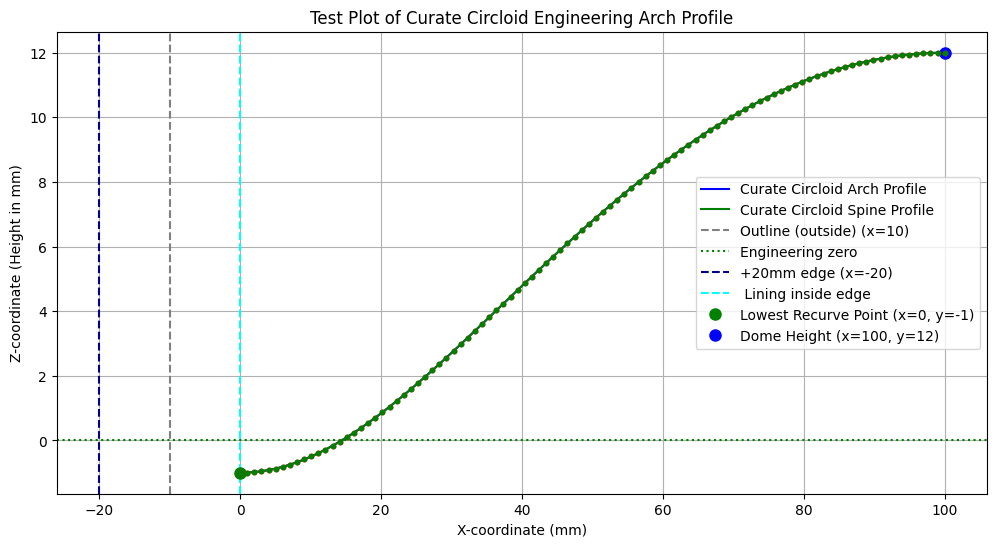

In [ ]:
# @title

# --- Test Recurve ---
# basic test

# Generate x-coordinates for plotting
# x_plot will cover the rim and the curve segment
x_plot_archA = np.linspace(0, +100, 100)

# Call the function to get the arch points

# note the curtate function will take the recurve depth+max height as the curve Z length

test_arch_dataA = create_curtatecycloid_wide(
    curve_upper_y=0,
    curve_lower_y=100,
    curve_max_height=12,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_archA,
    rim_width=10)

test_spine_dataA = create_curtatecycloid_wide(
    curve_upper_y=0,
    curve_lower_y=100,
    curve_max_height=12,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_archA,
    rim_width=10)

# we will need to manually offset:

# Separate x and y values for plotting
x_values = [p[0] for p in test_arch_dataA]
y_values = [p[1]-Parameter_EngRecurveDepth for p in test_arch_dataA]

x_values_spine = [p[0] for p in test_spine_dataA]
y_values_spine = [p[1]-Parameter_EngRecurveDepth for p in test_spine_dataA]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_values, label='Curate Circloid Arch Profile', color='blue')
plt.scatter(x_values, y_values, s=10, color='red', zorder=5) # Show individual points

plt.plot(x_values_spine, y_values_spine, label='Curate Circloid Spine Profile', color='green')
plt.scatter(x_values_spine, y_values_spine, s=10, color='green', zorder=5) # Show individual points

# Add markers for key points
plt.axvline(x=-Parameter_OutlineRibLiningThickness, color='gray', linestyle='--', label=f'Outline (outside) (x={Parameter_OutlineRibLiningThickness})')
plt.axhline(y=0, color='green', linestyle=':', label=f'Engineering zero')

plt.axvline(x=-20, color='darkblue', linestyle='--', label=f'+20mm edge (x=-20)')
plt.axvline(x=0, color='cyan', linestyle='--', label=f' Lining inside edge')

plt.plot([0], [-Parameter_EngRecurveDepth], 'go', markersize=8, label=f'Lowest Recurve Point (x=0, y=-{Parameter_EngRecurveDepth})')
plt.plot([100], [Parameter_MeasuredFrontDomeHeight], 'bo', markersize=8, label=f'Dome Height (x=100, y={Parameter_MeasuredFrontDomeHeight})')


plt.xlabel('X-coordinate (mm)')
plt.ylabel('Z-coordinate (Height in mm)')
plt.title('Test Plot of Curate Circloid Engineering Arch Profile')
plt.grid(True)
plt.legend()
plt.gca().set_aspect('auto', adjustable='box') # Adjust aspect ratio for better visualization
plt.show()


This next test has a number of curves:
* Symetrical Transverse curve over X=0 (dark blue)
* Asymetrical Transverse curve over X-0 (cyan) - note the outline isn't symetrical so this curve test is important.
* The two narrow curves are for testing curves fully X above 0 and X below 0
* Asymetrical spine (green) for the front plate is plotted. Dashed line is the bridge position.
* Symetrical spine (pink) for the rear plate is plotted.

The lowest point is the recurve lowest point (hence below 0).

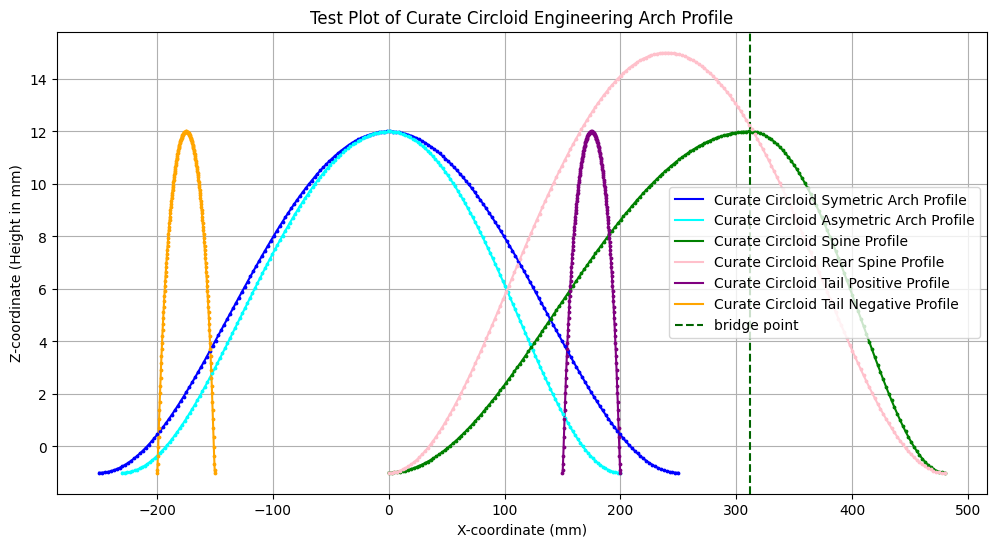

In [ ]:
# @title

# --- Test Plotting Code ---

# Define test parameters for the curate circloid arch
# These are example values; adjust as needed to see different arch shapes.

test_rim_width = Parameter_OutlineRibLiningRecuveOffset # Use the derived rim width
test_rim_height = RimEngineeringHeight # Use the derived rim height

# For the curve segment itself:
# Let's assume the curve starts at the end of the rim and goes towards a peak.
# `curve_length_target` could be the overall length of the curving part.
# `curve_height_target` could be the maximum height of the arch at its peak.
# Let's set some reasonable values for demonstration.

test_curve_length_target = 251.0 # Horizontal extent of the curve after the rim starts
test_curve_height_target = FrontDomeEngineeringHeight    # Engineering height from plate base
test_x_offset_curve_start = Parameter_OutlineRibLiningThickness # so the base of the curve is on the lining
test_y_offset_curve_base =  RecurveEngineeringHeight # Engineering height from plate base

# Generate x-coordinates for plotting
# x_plot will cover the rim and the curve segment
x_plot_spine = np.linspace(0, 480, 200)
x_plot_spine_rear = np.linspace(0, 480, 200)
x_plot_arch = np.linspace(250, -250, 200)
x_plot_arch_asym = np.linspace(200, -230, 200)
x_plot_tailP = np.linspace(150, 200, 200)
x_plot_tailN = np.linspace(-150, -200, 200)

# Call the function to get the arch points

# Remember the curve lengths are NOT the x position (x_list) but provide
# the symetric/asymetric lengths of the curves.
# AND the total height of the curve is height+recurve depth
# it will need manual adjustment for transition of depth if required.

# create a fully symetric curve over X=0 with equal lengths
test_arch_data = create_curtatecycloid_wide(
    curve_upper_y=250,
    curve_lower_y=-250,
    curve_max_height=Parameter_MeasuredFrontDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_arch,
    rim_width=Parameter_OutlineRibLiningThickness)

# create an asymetrical curve over X=0 with non-equal lengths
test_arch_data_asym = create_curtatecycloid_wide(
    curve_upper_y=200,
    curve_lower_y=-230,
    curve_max_height=Parameter_MeasuredFrontDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_arch_asym,
    rim_width=Parameter_OutlineRibLiningThickness)

# create a symetrical curve with equal side not spanning X=0 but X+ to X+
test_tail_arch_dataP = create_curtatecycloid_wide(
    curve_upper_y=(200-150)/2.0,
    curve_lower_y=(200-150)/2.0,
    curve_max_height=Parameter_MeasuredFrontDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_tailP,
    rim_width=Parameter_OutlineRibLiningThickness)

# create a symetrical curve with equal side not spanning X=0 but X- to X-
# note that the lenth isn't negative.
test_tail_arch_dataN = create_curtatecycloid_wide(
    curve_upper_y=(200-150)/2.0,
    curve_lower_y=(200-150)/2.0,
    curve_max_height=Parameter_MeasuredFrontDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_tailN,
    rim_width=Parameter_OutlineRibLiningThickness)

# create a non-symetrical spine curve
test_spine_data = create_curtatecycloid_wide(
    curve_upper_y=480-Parameter_BridgeXPoint,
    curve_lower_y=Parameter_BridgeXPoint,
    curve_max_height=Parameter_MeasuredFrontDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_spine,
    rim_width=Parameter_OutlineRibLiningThickness)

# create a symetrical spine curve for the back
test_rear_spine_data = create_curtatecycloid_wide(
    curve_upper_y=480/2.0,
    curve_lower_y=480/2.0,
    curve_max_height=Parameter_MeasuredRearDomeHeight,
    y_recurve_depth=Parameter_EngRecurveDepth,
    x_list=x_plot_spine,
    rim_width=Parameter_OutlineRibLiningThickness)

# Separate x and y values for plotting
x_values = [p[0] for p in test_arch_data]
y_values = [p[1]-Parameter_EngRecurveDepth for p in test_arch_data]

x_values_asym = [p[0] for p in test_arch_data_asym]
y_values_asym = [p[1]-Parameter_EngRecurveDepth for p in test_arch_data_asym]

x_values_spine = [p[0] for p in test_spine_data]
y_values_spine = [p[1]-Parameter_EngRecurveDepth for p in test_spine_data]

x_values_rear_spine = [p[0] for p in test_rear_spine_data]
y_values_rear_spine = [p[1]-Parameter_EngRecurveDepth for p in test_rear_spine_data]

x_values_tailP = [p[0] for p in test_tail_arch_dataP]
y_values_tailP = [p[1]-Parameter_EngRecurveDepth for p in test_tail_arch_dataP]
x_values_tailN = [p[0] for p in test_tail_arch_dataN]
y_values_tailN = [p[1]-Parameter_EngRecurveDepth for p in test_tail_arch_dataN]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_values, label='Curate Circloid Symetric Arch Profile', color='blue')
plt.scatter(x_values, y_values, s=3, color='blue', zorder=5) # Show individual points

plt.plot(x_values_asym, y_values_asym, label='Curate Circloid Asymetric Arch Profile', color='cyan')
plt.scatter(x_values_asym, y_values_asym, s=3, color='cyan', zorder=5) # Show individual points

plt.plot(x_values_spine, y_values_spine, label='Curate Circloid Spine Profile', color='green')
plt.scatter(x_values_spine, y_values_spine, s=3, color='green', zorder=5) # Show individual points

plt.plot(x_values_rear_spine, y_values_rear_spine, label='Curate Circloid Rear Spine Profile', color='pink')
plt.scatter(x_values_rear_spine, y_values_rear_spine, s=3, color='pink', zorder=5) # Show individual points

plt.plot(x_values_tailP, y_values_tailP, label='Curate Circloid Tail Positive Profile', color='purple')
plt.scatter(x_values_tailP, y_values_tailP, s=3, color='purple', zorder=5) # Show individual points

plt.plot(x_values_tailN, y_values_tailN, label='Curate Circloid Tail Negative Profile', color='orange')
plt.scatter(x_values_tailN, y_values_tailN, s=3, color='orange', zorder=5) # Show individual points

plt.axvline(x=Parameter_BridgeXPoint, color='darkgreen', linestyle='--', label=f'bridge point')

# Add markers for key points

plt.xlabel('X-coordinate (mm)')
plt.ylabel('Z-coordinate (Height in mm)')
plt.title('Test Plot of Curate Circloid Engineering Arch Profile')
plt.grid(True)
plt.legend()
plt.gca().set_aspect('auto', adjustable='box') # Adjust aspect ratio for better visualization
plt.show()


Test Spine curve plots

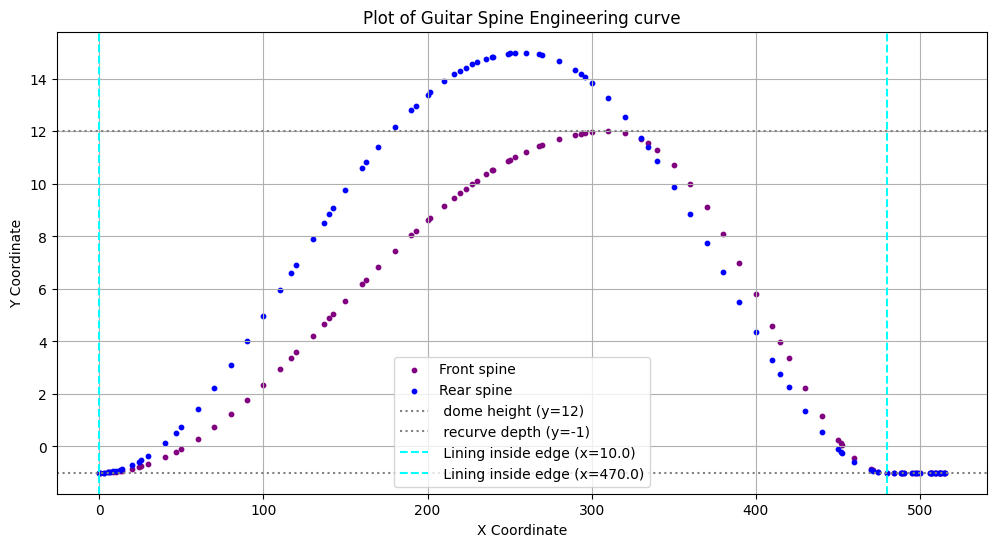

In [ ]:
# @title
# Call the create_spine function
calculated_spine_points = create_spine(height_segment=Parameter_MeasuredFrontDomeHeight)

# Extract x and y coordinates from the spine points for plotting
spine_x = [p[0] for p in calculated_spine_points]
spine_y = [p[1]-Parameter_EngRecurveDepth for p in calculated_spine_points]

calculated_rear_spine_points = create_spine(height_segment=Parameter_MeasuredRearDomeHeight,
                                            bridge_x_coord=((max(spine_x)-min(spine_x))/2.0))

rear_spine_x = [p[0] for p in calculated_rear_spine_points]
rear_spine_y = [p[1]-Parameter_EngRecurveDepth for p in calculated_rear_spine_points]

# Plot the spine
plt.figure(figsize=(12, 6))
#plt.plot(spine_x, spine_y, label='Guitar Spine', color='purple')
plt.scatter(spine_x, spine_y, color='purple', s=10, label='Front spine')
plt.scatter(rear_spine_x, rear_spine_y, color='blue', s=10, label='Rear spine')
plt.axhline(y=Parameter_MeasuredFrontDomeHeight, color='gray', linestyle=':', label=f' dome height (y={Parameter_MeasuredFrontDomeHeight})')
plt.axhline(y=-Parameter_EngRecurveDepth, color='gray', linestyle=':', label=f' recurve depth (y=-{Parameter_EngRecurveDepth})')
plt.axvline(x=Parameter_GuitarOutlineMinX, color='cyan', linestyle='--', label=f' Lining inside edge (x={Parameter_GuitarOutlineMinX+Parameter_OutlineRibLiningThickness})')
plt.axvline(x=Parameter_GuitarOutlineMaxX, color='cyan', linestyle='--', label=f' Lining inside edge (x={Parameter_GuitarOutlineMaxX-Parameter_OutlineRibLiningThickness})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Guitar Spine Engineering curve')
plt.grid(True)
plt.legend()
plt.show()

Test Transverse curve plots

In [ ]:
# @title
def create_transverse_curves(spine_interpolator,
                             df_imported,
                             RecurveEngineeringHeight,
                             RimEngineeringHeight,
                             Parameter_OutlineRibLiningRecuveOffset,
                             Parameter_OutlineRibLiningThickness):
  """
  Generates 3D points for all transverse arch profiles across the guitar top.

  Args:
    spine_interpolator (interp1d): An interpolation function for the guitar spine,
                                    mapping X-coordinates to Z-heights.
    df_imported (pd.DataFrame): DataFrame containing the guitar outline points ('X', 'Y').
    RecurveEngineeringHeight (float): The engineering height of the recurve's lowest point.
    RimEngineeringHeight (float): The engineering height of the rim.
    Parameter_OutlineRibLiningRecuveOffset (float): The width of the flat section at the arch's rim.
    Parameter_OutlineRibLiningThickness (float): The thickness parameter used for the lining
                                                 which also acts as the lining_limit_x for recurve.

  Returns:
    list: A list of (X, Y, Z) tuples representing the 3D points of all transverse curves.
  """
  all_transverse_curves_3d = []

  # 1. Group df_imported by unique 'X' coordinates
  # Ensure df_imported is sorted by X and then Y to get consistent groups
  df_sorted = df_imported.sort_values(by=['X', 'Y']).reset_index(drop=True)
  unique_x_coords = df_sorted['X'].unique()

  for x_station in unique_x_coords:
    # Filter to get all 'Y' coordinates for the current x_station
    y_coords_at_x = df_sorted[df_sorted['X'] == x_station]['Y'].values

    # print(f" x={x_station} = {len(y_coords_at_x)} points")

    # 2. Determine max_pos_y and min_neg_y
    max_pos_y = 0.0
    if (y_coords_at_x >= 0).any():
      max_pos_y = np.max(y_coords_at_x[y_coords_at_x >= 0])

    min_neg_y = 0.0
    if (y_coords_at_x < 0).any():
      min_neg_y = np.min(y_coords_at_x[y_coords_at_x < 0])

    # 3. Calculate spine_z_height for the x_station
    spine_z_height = spine_interpolator(x_station)
    if np.isnan(spine_z_height):
      spine_z_height = 0.0 # Default to 0 if interpolation yields NaN

    # 4. Generate a sorted array of Y-coordinates for the transverse arch
    # Ensure min_neg_y, 0.0 (if between min_neg_y and max_pos_y), and max_pos_y are included.
    y_coords_raw = np.arange(min_neg_y, max_pos_y + 2.0, 2.0) # +2.0 to ensure max_pos_y is included if it's a multiple of 2

    # Add 0.0 explicitly if it's within the range (e.g., if it's a valid point on the centerline)
    if min_neg_y < 0.0 and max_pos_y > 0.0:
      y_coords_raw = np.append(y_coords_raw, 0.0)

    # Add min_neg_y and max_pos_y explicitly in case arange missed them due to float precision
    y_coords_raw = np.append(y_coords_raw, [min_neg_y, max_pos_y])

    # Ensure uniqueness and sort the Y-coordinates
    y_coords_for_transverse_arch = np.unique(y_coords_raw)
    y_coords_for_transverse_arch.sort() # Ensure they are sorted

    # Ensure y_coords_for_transverse_arch covers the actual range [min_neg_y, max_pos_y]
    # Filter to only include points within the actual Y span of this X station's outline
    y_coords_for_transverse_arch = y_coords_for_transverse_arch[
        (y_coords_for_transverse_arch >= min_neg_y) &
        (y_coords_for_transverse_arch <= max_pos_y)
    ]

    # 5. Call create_curtate_cycloid_wide function
    # The x_list for create_curtate_cycloid_wide represents the local y-coordinates for the arch function,
    # which are distances from the centerline (0). So we need to convert `y_coords_for_transverse_arch`
    # to their absolute distances from the centerline, maintaining original sign for curve_upper_y/curve_lower_y context.

    # The `create_curtate_cycloid_wide` expects `x_list` to represent distances for half-arches,
    # it then reconstructs the full arch. It needs to know the full span.
    # We need to determine how to map `min_neg_y` and `max_pos_y` to its `curve_upper_y` and `curve_lower_y`.
    # For a full arch spanning across Y=0, `curve_upper_y` would be `max_pos_y` and `curve_lower_y` would be `min_neg_y`.
    # The `x_list` should be the absolute distances from the center for half-arches, then mapped back.

    # The x_list for the curtate cycloid should be from 0 to max(abs(min_neg_y), abs(max_pos_y))
    # and then the function internally handles mirroring. However, the current create_curtate_cycloid_wide
    # expects x_list to be the actual y-coordinates for each segment.

    # Let's adjust `y_coords_for_transverse_arch` to reflect distances for the half-arches
    # and let `create_curtate_cycloid_wide` handle full span based on provided curve_upper_y/curve_lower_y
    # We will pass the y-coordinates as they are, and `create_curtate_cycloid_wide` needs to interpret them correctly.

    # print(f" ({min_neg_y}, {max_pos_y}) = {spine_z_height}")

    if min_neg_y==0 or max_pos_y==0:
      continue

    transverse_arch_points = create_curtatecycloid_wide(
        curve_upper_y=max_pos_y,
        curve_lower_y=min_neg_y,
        curve_max_height=spine_z_height,
        y_recurve_depth=Parameter_EngRecurveDepth,
        x_list=list(y_coords_for_transverse_arch), # Pass the full list of Y values
        rim_width=Parameter_OutlineRibLiningRecuveOffset
    )

    # 6. Append resulting 3D points
    for y_local, z_arch in transverse_arch_points:
      all_transverse_curves_3d.append((x_station, y_local, z_arch))

  # print(f"Generated {len(all_transverse_curves_3d)} 3D points for engineering transverse curves.")
  return all_transverse_curves_3d



In [ ]:
# @title
def create_unique_spine_points(calculated_spine_points):
  x_coords = [p[0] for p in calculated_spine_points]
  z_heights = [p[1]-Parameter_EngRecurveDepth for p in calculated_spine_points]
  # Combine points, ensuring unique X values. Use a dictionary to keep the last Z for each X.
  # For a spine, X values should generally map to a single Z, so this is acceptable.
  unique_points_dict = {}
  for x, z in zip(x_coords, z_heights):
    if x<Parameter_GuitarOutlineMaxX :
      unique_points_dict[x] = z

  # Sort the unique points by X-coordinate
  sorted_unique_points = sorted(unique_points_dict.items())

  sorted_spine_x_unique = [p[0] for p in sorted_unique_points]
  sorted_spine_z_unique = [p[1] for p in sorted_unique_points]
  return (sorted_spine_x_unique, sorted_spine_z_unique)

In [ ]:
# @title
def create_spine_interpolator_for_plot(sorted_spine_x_unique, sorted_spine_z_unique):
  # Create the linear interpolator with unique x-values
  spine_interpolator = interp1d(sorted_spine_x_unique, sorted_spine_z_unique, kind='linear', fill_value='extrapolate')
  return spine_interpolator

In [ ]:
# @title
def create_transverse_curves_for_plot( spine_interpolator,
                                      df_imported):
  all_transverse_curves_3d = []
  """
  # Get unique X, Y pairs from df_imported to avoid duplicate calculations for the same X, Y points
  # Assuming df_imported contains the guitar outline points
  unique_outline_points = df_imported[['X', 'Y']].drop_duplicates().values

  for outline_x, outline_y in unique_outline_points:
    # 3. For each outline_x, use the spine_interpolator to get the spine_z_height
    spine_z_height = spine_interpolator(outline_x)
    # Handle potential NaN values from the interpolator
    if np.isnan(spine_z_height):
        spine_z_height = 0.0

    # 4. Create a list of Y-coordinates for the transverse arch
    # Ensuring the step is not 0 for arange if abs(outline_y) is very small or 0
    if abs(outline_y) > 0.1: # Threshold to ensure meaningful range
        y_coords_for_arch = np.arange(0, abs(outline_y), 2)
    else:
        y_coords_for_arch = np.array([0]) # Just the center point if outline_y is near 0

    # 5. Call the create_curtatecycloid_wide function
    # The length for the arch function should be the span of the Y-coordinates
    # Ensure length is not zero to prevent division by zero in create_average_arch
    arch_length = max(1e-6, abs(outline_y))

    transverse_arch_raw_points = create_curtatecycloid_wide(
        curve_upper_y=outline_y,
        curve_lower_y=-outline_y,
        curve_max_height=spine_z_height,
        y_recurve_depth=Parameter_EngRecurveDepth,
        x_list=y_coords_for_arch,
        rim_width=0,
        asymetric_curve=False
    )

    # 6. process the coordincates into all transverse curves
    # AI: don't normalise and scale the arch as the curve will not fit correctly.

    for raw_y_for_arch, raw_z_for_arch in transverse_arch_raw_points:
      y_coordinate = raw_y_for_arch
      if outline_y < 0:
        y_coordinate = outline_y+raw_y_for_arch
      else:
        y_coordinate = outline_y-raw_y_for_arch
      all_transverse_curves_3d.append((outline_x, y_coordinate, raw_z_for_arch))

  print(f"Generated {len(all_transverse_curves_3d)} 3D points for engineering transverse curves.")
  """

  # Generate the transverse curves
  all_transverse_curves_3d = create_transverse_curves(
    spine_interpolator,
    df_imported,
    RecurveEngineeringHeight,
    RimEngineeringHeight,
    Parameter_OutlineRibLiningRecuveOffset,
    Parameter_OutlineRibLiningThickness
  )
  print(f"Generated {len(all_transverse_curves_3d)} 3D points for engineering transverse curves.")
  # Extract X, Y, Z coordinates for plotting
  transverse_x = [p[0] for p in all_transverse_curves_3d]
  transverse_y = [p[1] for p in all_transverse_curves_3d]
  transverse_z = [p[2]-Parameter_EngRecurveDepth for p in all_transverse_curves_3d]
  return (transverse_x, transverse_y, transverse_z)

In [ ]:
# @title
def plot_transverse_curves(transverse_x,
                           transverse_y,
                           transverse_z,
                           sorted_spine_x_unique,
                           sorted_spine_z_unique,
                           mark_title=""):
  """
    This is showing the engineering curves for the spine and transverse arches
    They should be recurve negative, below the outline acting as the engineering Z=0.
    Before this can be used in the contours, it will need any padding or thickness added as required.
  """
  fig = plt.figure(figsize=(12, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Set a default viewing angle for better visualization
  ax.view_init(elev=5, azim=95, roll=0)

  # 1. Plot the extracted transverse curve points as a scatter plot
  ax.scatter(transverse_x, transverse_y, transverse_z, s=1, alpha=0.5, label='Transverse Eng Arch Curves', color='red')

  # 2. Plot the original guitar outline at Z=0
  # Ensure outline_x_data and outline_y_data are available (from previous cells)
  # We assume df_imported is the current resampled and enlarged outline.
  outline_x_data = df_imported['X'].values
  outline_y_data = df_imported['Y'].values
  outline_z_data = np.zeros_like(outline_x_data) # All outline points are at Z=0
  ax.plot(outline_x_data, outline_y_data, outline_z_data, label='Guitar Outline (Z=0)', color='blue', linewidth=2)

  # 3. Plot the guitar spine using sorted_spine_x_unique and sorted_spine_z_unique
  # Ensure these variables are available (from previous cells)
  ax.plot(sorted_spine_x_unique, np.zeros_like(sorted_spine_x_unique), sorted_spine_z_unique, label='Guitar Spine', color='green', linewidth=2)

  # 4. Set labels
  ax.set_xlabel('X Coordinate (mm)')
  ax.set_ylabel('Y Coordinate (mm)')
  ax.set_zlabel('Z Height (mm)')

  # 5. Add a title
  ax.set_title(mark_title)

  # 6. Add a legend
  ax.legend()

  # 7. Display the plot
  plt.show()

Generated 9332 3D points for engineering transverse curves.


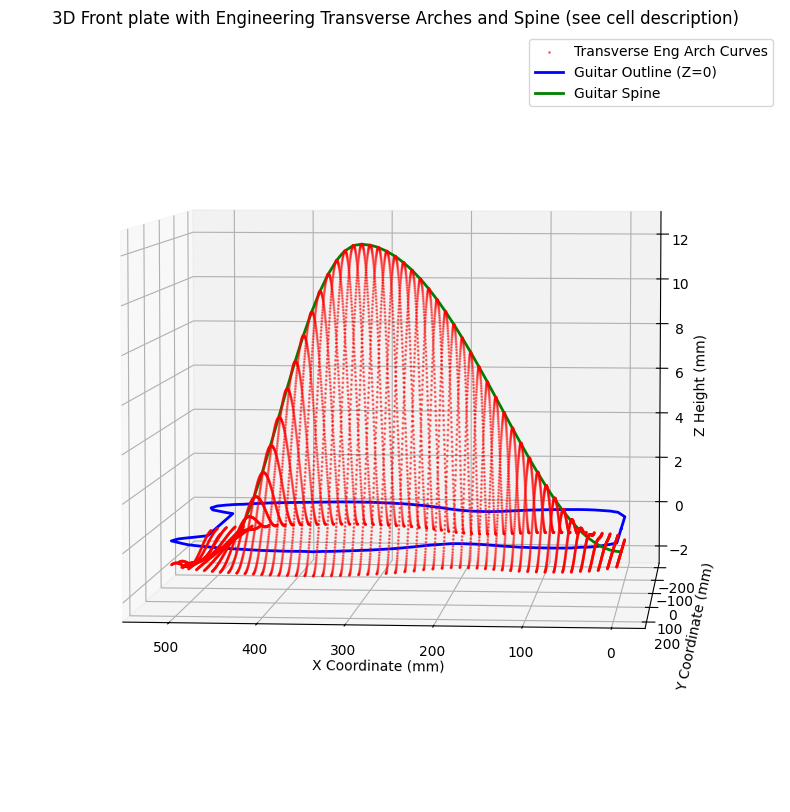

In [ ]:
# @title 3D plot of engineering curves of front plate

(sorted_spine_x_unique, sorted_spine_z_unique) = create_unique_spine_points(calculated_spine_points)
spine_interpolator = create_spine_interpolator_for_plot(sorted_spine_x_unique, sorted_spine_z_unique)
(transverse_x,transverse_y,transverse_z) = create_transverse_curves_for_plot(spine_interpolator, df_imported)
plot_transverse_curves(transverse_x, transverse_y, transverse_z,
                       sorted_spine_x_unique, sorted_spine_z_unique,
                       '3D Front plate with Engineering Transverse Arches and Spine (see cell description)')


Rear engineering plot

In [ ]:
# @title 3D plot of engineering curves of rear plate

(sorted_spine_x_unique_rear, sorted_spine_z_unique_rear) = create_unique_spine_points(calculated_rear_spine_points)
rear_spine_interpolator = create_spine_interpolator_for_plot(sorted_spine_x_unique_rear, sorted_spine_z_unique_rear)
(rear_transverse_x,rear_transverse_y,rear_transverse_z) = create_transverse_curves_for_plot(rear_spine_interpolator, df_imported)
plot_transverse_curves(rear_transverse_x, rear_transverse_y, rear_transverse_z,
                       sorted_spine_x_unique_rear, sorted_spine_z_unique_rear,
                       '3D Rear plate with Engineering Transverse Arches and Spine (see cell description)')


Generated 9332 3D points for engineering transverse curves.




---



---



**FRONT AND REAR PLATE UPPER SURFACE CONTOUR MAP PLOT**

The contour maps are referenced on the base of the wood with the height to the upper surface - this includes padding, recurve lowest point and constant thickness. For example with the 5mm constant thickness:

---- Upper Surface line ---- the outside surface of the plate

+ 2.5 mm 1/2 thickness

+ engineering curve line

+ 2.5 mm 1/2 thickness

+ 1.0 mm recurve depth

---- Lower Surface line ---- the inside surface of the plate

+ 1.0 mm base padding (sanded away at the end for levelling)

---- PLATE Base (0mm height) ----

This ensures that the recurve lowest point (including 1/2 thickness from the engineering sits above the padding. The lining edge should therefore be joined after removing the base padding onto the lower surface.
The padding is provided simply to allow for any issues/dents/chip out/cleanup scraping before joining etc.

IMPORTANT: The rear contour map is created as if looking from the front of the guitar. Ie 'UP' for the rear plate is into the guitar instead of out of the guitar as it should be. Thus the plot needs mirrororing so you're looking at the back of it.
For non-symetrical outlines this detail is extremely important. Without mirroring the resulting carved top will not fit and will not be the correct shape. You have been warned.


In [ ]:
# @title code
def plot_contour_map( transverse_x,
                      transverse_y,
                      transverse_z,
                      df_imported,
                      contour_levels=[],
                      mark_fretboard=True,
                      mark_title="") :

  # Convert to numpy arrays and filter out NaN values
  filtered_transverse_x = np.array([x for x in transverse_x if not np.isnan(x)])
  filtered_transverse_y = np.array([y for y in transverse_y if not np.isnan(y)])

  outline_x_data = df_imported['X'].values
  outline_y_data = df_imported['Y'].values

  # Handle cases where filtered arrays might be empty or contain only a single unique value
  if filtered_transverse_x.size > 1:
    min_x, max_x = np.min(filtered_transverse_x), np.max(filtered_transverse_x)
  elif filtered_transverse_x.size == 1:
    min_x, max_x = filtered_transverse_x[0], filtered_transverse_x[0] + 1e-6 # Add small epsilon to define a range
  else:
    min_x, max_x = 0, 1 # Default range if no valid x values

  if filtered_transverse_y.size > 1:
    min_y, max_y = np.min(filtered_transverse_y), np.max(filtered_transverse_y)
  elif filtered_transverse_y.size == 1:
    min_y, max_y = filtered_transverse_y[0], filtered_transverse_y[0] + 1e-6 # Add small epsilon to define a range
  else:
    min_y, max_y = 0, 1 # Default range if no valid y values

  # Create 1D arrays of evenly spaced coordinates
  num_points = 800 # Adjust resolution as needed
  grid_x_1d = np.linspace(min_x, max_x, num_points)
  grid_y_1d = np.linspace(min_y, max_y, num_points)

  # Create 2D meshgrid
  grid_x, grid_y = np.meshgrid(grid_x_1d, grid_y_1d)

  print(f"Created a grid with X range [{min_x:.2f}, {max_x:.2f}] and Y range [{min_y:.2f}, {max_y:.2f}]")
  print(f"Grid shape: {grid_x.shape}")

  # Filter transverse_z for NaN values, aligning with filtered x and y

  # Note: transverse_x_filtered and transverse_y_filtered were created in the previous step.
  # We need to ensure that the points and values passed to griddata are clean.
  # Combine filtered X, Y, and Z points into a list of (x, y, z) tuples
  # for upper surface we add thickness/2.0 on top of the engineering curve.

  # we now need to add any thicknessing to the engineering curve in z
  """
    The general structure is as follows, given a 5 mm thickness:

    ---- Upper Surface line ---- the outside surface of the plate
      +2.5 mm 1/2 thickness
      + engineering curve (this will be from -recurve depth to height)
      +2.5 mm 1/2 thickness
      +1.0 mm recurve depth
      ---- Lower Surface line ---- the inside surface of the plate
      +1.0 mm base padding (sanded away at the end for levelling)
      ---- PLATE Base (0mm height) ----
  """

  surface_z = Parameter_BasePadding+Parameter_EngRecurveDepth+Parameter_Thickness/2.0+Parameter_Thickness/2.0 # + z

  valid_points_values = [(x, y, z+surface_z) for x, y, z in zip(transverse_x, transverse_y, transverse_z) if not np.isnan(x) and not np.isnan(y) and not np.isnan(z)]

  # Separate into points (x, y) and values (z)
  points = np.array([(p[0], p[1]) for p in valid_points_values])
  values = np.array([p[2] for p in valid_points_values])

  # Interpolate the Z-values onto the grid, filling NaN areas with 0.0
  grid_z = griddata(points, values, (grid_x, grid_y), method='nearest', fill_value=0.0)

  # print("Interpolated Z-values onto the grid successfully using 'nearest' method.")

  # Define Contour Levels
  min_z = np.nanmin(grid_z)
  max_z = np.nanmax(grid_z)

  # Define default contour levels with a step of 0.1mm
  if contour_levels==[]:
    contour_levels = np.arange(min_z-2, max_z + 0.25, 0.1)

  print(f"Minimum Z-value: {min_z:.2f}")
  print(f"Maximum Z-value: {max_z:.2f}")
  print(f"Number of contour levels created: {len(contour_levels)}")

  plt.figure(figsize=(12, 10))

  # Create the contour plot
  contour = plt.contourf(grid_x, grid_y, grid_z, levels=contour_levels, cmap='viridis')

  # Filter out NaN values from outline data before creating path
  # This assumes outline_x_data and outline_y_data are numpy arrays or similar lists
  valid_outline_indices = ~np.isnan(outline_x_data) & ~np.isnan(outline_y_data)
  filtered_outline_x = outline_x_data[valid_outline_indices]
  filtered_outline_y = outline_y_data[valid_outline_indices]

  # Combine X and Y data into a list of vertices
  outline_vertices = list(zip(filtered_outline_x, filtered_outline_y))

  # Ensure there are enough vertices to form a path
  if outline_vertices:
    # Define the path codes (1 for MOVETO, 2 for LINETO, 79 for CLOSEPOLY)
    # For a simple outline, we start at the first point (MOVETO) and draw lines to others (LINETO),
    # then close the polygon (CLOSEPOLY).
    path_codes = [Path.MOVETO] + [Path.LINETO] * (len(outline_vertices) - 1) + [Path.CLOSEPOLY]
    outline_path = Path(outline_vertices + [outline_vertices[0]], path_codes)

    # Create a PathPatch from the outline path
    outline_patch = PathPatch(outline_path, facecolor='none', edgecolor='black', linewidth=2, zorder=10)

    # Get the current axes and add the patch
    ax = plt.gca()
    ax.add_patch(outline_patch)

    # Apply clipping to the collections of the contour object
    # As a workaround, iterate over the collections *added to the axes* and apply the clip path.
    # The contourf function adds its filled regions as PathCollections to ax.collections
    for col in ax.collections:
        # Check if the collection is a PathCollection (which contourf uses for filled contours)
        if isinstance(col, matplotlib.collections.PathCollection):
            col.set_clip_path(outline_patch)
  else:
    print("Warning: No valid outline vertices found to create a mask.")

  # Add a color bar to show the Z-height mapping
  plt.colorbar(contour, label='Z Height (mm)')

  # Add labels and title
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title(mark_title)

  # fret board
  if mark_fretboard:
    plt.plot([0,100],[41,41], ',-w' )
    plt.plot([100,100],[41,-41], ',-w' )
    plt.plot([100,0],[-41,-41], ',-w' )

  # head block
  plt.plot([0,0],[97,97], ',-w' )
  plt.plot([0,27.5],[97,78], ',-w' )
  plt.plot([0,0],[-97,-97], ',-w' )
  plt.plot([0,27.5],[-97,-78], ',-w' )
  plt.plot([27.5,27.5],[-78,78], ',-w' )

  # tail block
  plt.plot([453,453],[48.5,-48.5], ',-w' )
  plt.plot([453,490],[48.5,48.5], ',-w' )
  plt.plot([453,490],[-48.5,-48.5], ',-w' )

  plt.plot(Parameter_BridgeXPoint, 0, 'go', markersize=8, label=f'Bridge point')

  # Add grid for better readability
  plt.grid(True)

  # Ensure equal aspect ratio if desired (can make the plot look more geometrically accurate)
  plt.gca().set_aspect('equal', adjustable='box')

  plt.show()
  #print("2D Z contour plot masked by guitar outline displayed successfully.")


Created a grid with X range [0.00, 515.00] and Y range [-207.50, 212.00]
Grid shape: (800, 800)
Minimum Z-value: 5.23
Maximum Z-value: 19.00
Number of contour levels created: 21


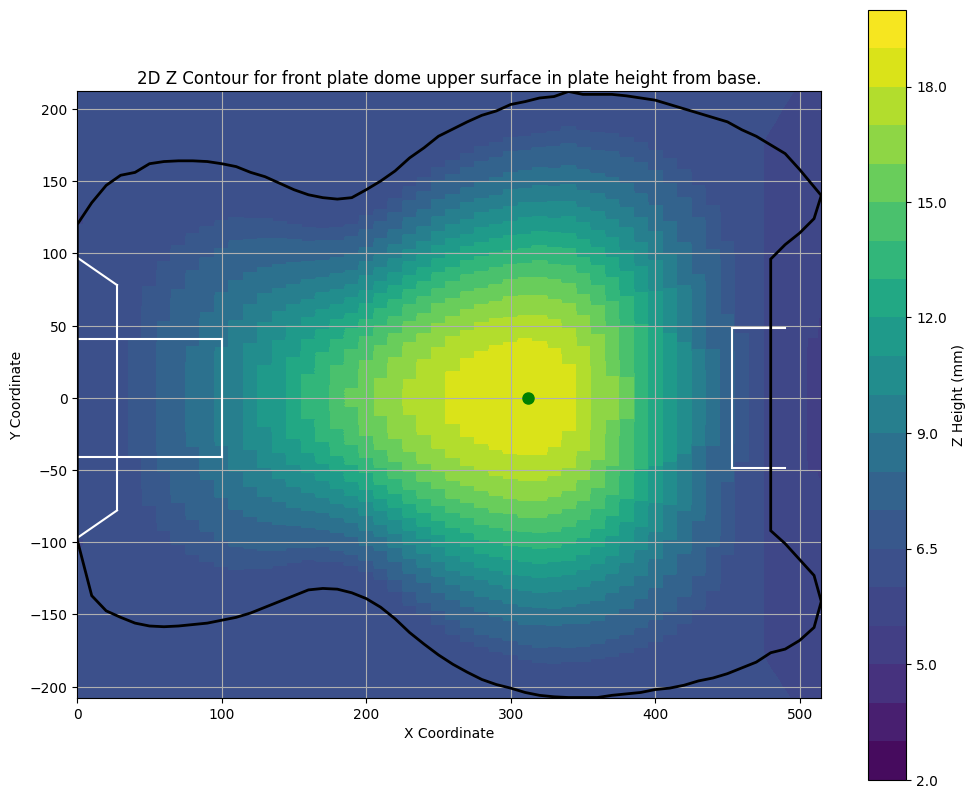

In [ ]:
#@title Contour map plot of front plate upper surface
plot_contour_map( transverse_x,
                  transverse_y,
                  transverse_z,
                  df_imported,
                  Parameter_ArchContoursList,
                  mark_title="2D Z Contour for front plate dome upper surface in plate height from base.")


REAR PLATE CONTOUR MAP PLOT (see mirroring note)

In [ ]:
#@title Contour map plot of rear plate upper surface (looking from top of front plate - so this needs appropriate mirroring)
print(" *** IMPORTANT NOTE - THIS WILL REQUIRE MIRRORING (as you're looking down from the front plate through the guitar) *** ")
plot_contour_map( rear_transverse_x,
                  rear_transverse_y,
                  rear_transverse_z,
                  df_imported,
                  Parameter_ArchRearContoursList,
                  mark_fretboard=False,
                  mark_title="2D Z Contour for rear plate dome upper surface in plate height from base. ")

 *** IMPORTANT NOTE - THIS WILL REQUIRE MIRRORING (as you're looking down from the front plate through the guitar) *** 
Created a grid with X range [0.00, 515.00] and Y range [-207.50, 212.00]
Grid shape: (800, 800)
Minimum Z-value: 5.47
Maximum Z-value: 22.00
Number of contour levels created: 19
